In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bri-data-hackathon-cr-optimization/sample_submission.csv
/kaggle/input/bri-data-hackathon-cr-optimization/data_description.csv
/kaggle/input/bri-data-hackathon-cr-optimization/train.csv
/kaggle/input/bri-data-hackathon-cr-optimization/test.csv


**Halo semuanya :)**

Di notebook kali ini, saya akan menjelaskan secara singkat mengenai konsep time-series serta bagaimana memodelkan time-series menggunakan ARIMA dan Prophet. Kedua teknik ini merupakan teknik yang paling sering diggunakan di time-series dan memiliki hasil yang cukup memuaskan. 

Pada tutorial ini, saya hanya menggunakan variabel `periode`, `kas_kantor` dan `kas_echannel`. Variabel yang lain **mungkin bermanfaat**, tetapi saya tidak akan menggunakan variabel lain tersebut.

Notebook ini tidak akan terlalu membahas EDA secara mendalam. Untuk EDA, silahkan referensi ke notebook lain.

**Apabila tutorial ini bermanfaat, mohon untuk bantu upvote dan apabila ada pertanyaan silakan ditanyakan, selama penulis mengerti apa yang ditanyakan, nanti akan dijawab**

## Loading library dan data yang diperlukan

In [2]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')

In [3]:
# Jalankan kode ini untuk install library
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 1.3 MB/s 
     |████████████████████████████████| 2.1 MB 7.9 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import fbprophet
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
train = pd.read_csv("../input/bri-data-hackathon-cr-optimization/train.csv")
train.head()

,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


## Data Processing

#### Filter data yang dibutuhkan saja

In [6]:
train = train[['periode', 'kas_kantor', 'kas_echannel']]
train.head()

,periode,kas_kantor,kas_echannel
0,2019-07-31,1.928940e+09,2.939100e+09
1,2019-08-01,2.492322e+11,2.839150e+09
2,2019-08-02,2.493411e+11,3.387550e+09
3,2019-08-03,2.493411e+11,3.876950e+09
4,2019-08-04,2.608817e+11,3.874250e+09


In [7]:
# Angka pada kas_kantor paling awal kelihatannya invalid, saya akan impute dari harga sesudahnya saja untuk simplicity
train['kas_kantor'].iloc[0] = train['kas_kantor'].iloc[1]
train.head()

,periode,kas_kantor,kas_echannel
0,2019-07-31,2.492322e+11,2.939100e+09
1,2019-08-01,2.492322e+11,2.839150e+09
2,2019-08-02,2.493411e+11,3.387550e+09
3,2019-08-03,2.493411e+11,3.876950e+09
4,2019-08-04,2.608817e+11,3.874250e+09


### Konversi `periode` menjadi format yang sesuai dan jadikan index dari dataset

In [8]:
train['periode'] = pd.to_datetime(train['periode'])
train.set_index(['periode'], inplace=True)
train.head()

,kas_kantor,kas_echannel
periode,,
2019-07-31,2.492322e+11,2.939100e+09
2019-08-01,2.492322e+11,2.839150e+09
2019-08-02,2.493411e+11,3.387550e+09
2019-08-03,2.493411e+11,3.876950e+09
2019-08-04,2.608817e+11,3.874250e+09


## Plotting

Mengapa penting? Selain untuk visualisasi, dalam melakukan prediksi time-series, opsi kita bukan hanya prediksi data mentah saja. **Kita bisa memprediksi dengan data transformasi (percent of changes, log, sqrt).**

Data time-series mayoritas adalah kombinasi dari data-data yang lain, misal kita mau memprediksi revenue yang merupakan kombinasi dari harga x jumlah konsumen x faktor tak terduga lainnya. Kita bisa **memprediksi masing-masing komponen lalu digabungkan** atau **memprediksi kombinasinya pada saat bersamaan.**

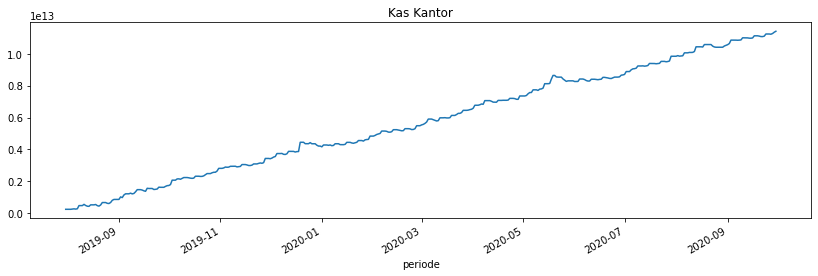

In [9]:
train['kas_kantor'].plot(title="Kas Kantor", figsize = (14, 4));

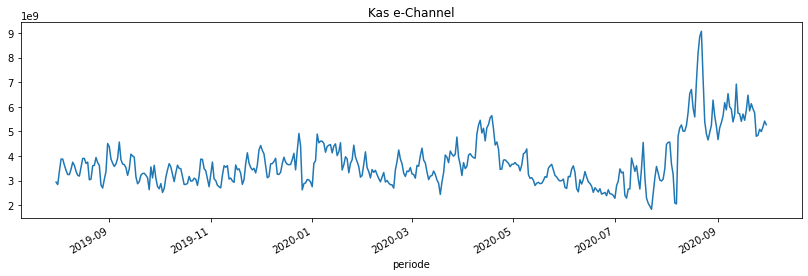

In [10]:
train['kas_echannel'].plot(title="Kas e-Channel", figsize = (14, 4));

### Kita juga bisa plot persentase dari perubahan data

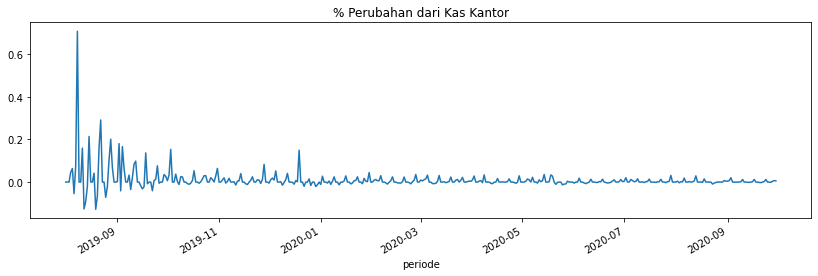

In [11]:
train['kas_kantor'].pct_change().plot(title="% Perubahan dari Kas Kantor", figsize = (14, 4));

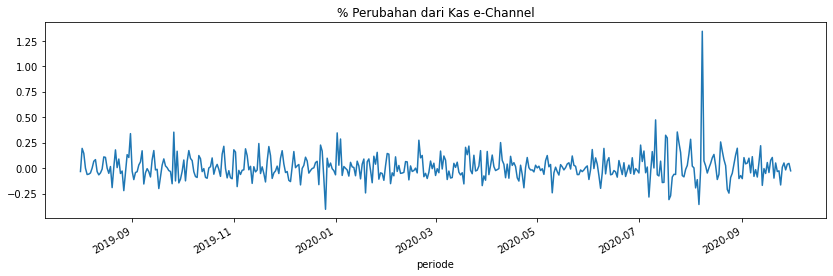

In [12]:
train['kas_echannel'].pct_change().plot(title="% Perubahan dari Kas e-Channel", figsize = (14, 4));

Pada kedua gambar di atas kita lihat bahwa persentase perubahan dari kas kantor sangat fluktuatif di awal, kemudian perlahan-lahan menjadi lebih stasioner. Sedangkan pada persentase perubahan dari kas echannel cenderung lebih konsisten, hanya saja ada nilai pencilan pada sekitar bulan Agustus.

## Resampling

Disini kita akan mencoba melakukan resampling data dari harian menjadi mingguan.

Ketika kita melakukan resampling, data yang tadinya 7 hari kita ubah menjadi 1 minggu. Ketika data itu diubah, kita bisa jumlahkan atau ambil rata-ratanya.

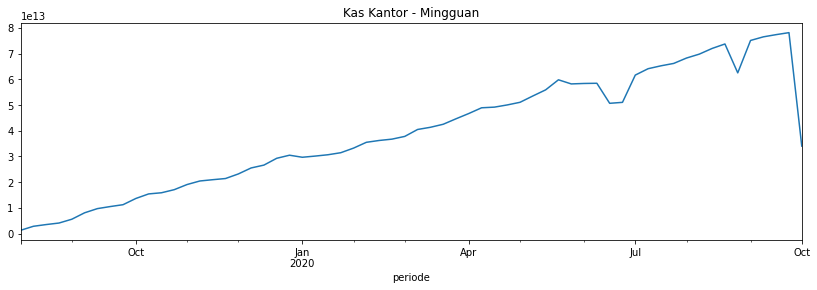

In [13]:
train['kas_kantor'].resample('W').sum().plot(title="Kas Kantor - Mingguan", figsize = (14, 4));

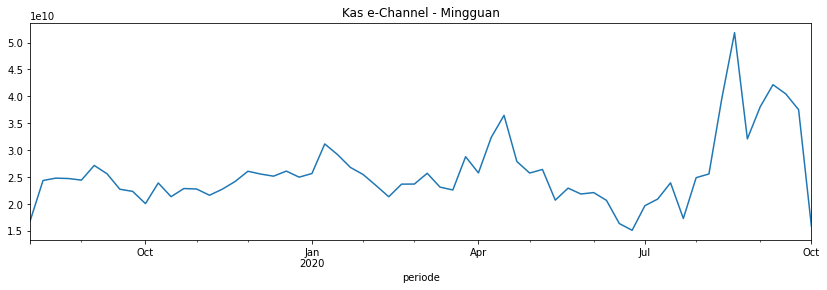

In [14]:
train['kas_echannel'].resample('W').sum().plot(title="Kas e-Channel - Mingguan", figsize = (14, 4));

### Autokorelasi

Autokorelasi adalah grafik yang menjelaskan bagaimana data pada hari-H berkorelasi dengan data pada H-1, H-2, dan seterusnya...

Ada dua grafik yang umumnya digunakan, ACF dan PACF (Partial ACF). Untuk perbedaannya, silakan cari referensi secara daring.

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

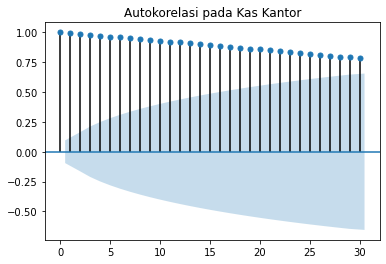

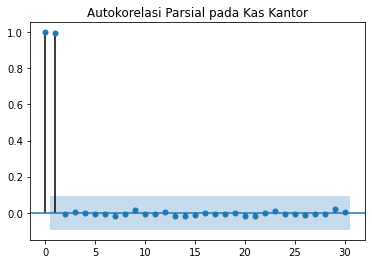

In [16]:
acf_plot = plot_acf(train['kas_kantor'], lags=30, title='Autokorelasi pada Kas Kantor')
pacf_plot = plot_pacf(train['kas_kantor'], lags=30, title='Autokorelasi Parsial pada Kas Kantor')

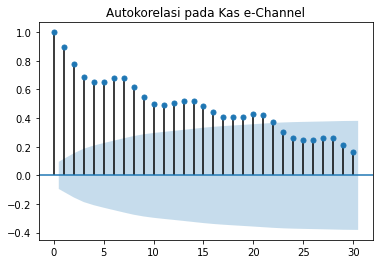

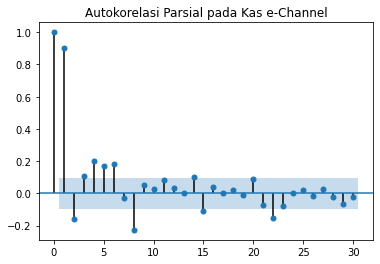

In [17]:
acf_plot = plot_acf(train['kas_echannel'], lags=30, title='Autokorelasi pada Kas e-Channel')
pacf_plot = plot_pacf(train['kas_echannel'], lags=30, title='Autokorelasi Parsial pada Kas e-Channel')

## SARIMA menggunakan Statsmodels

In [18]:
sar = sm.tsa.statespace.SARIMAX(train['kas_kantor'], 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           kas_kantor   No. Observations:                  425
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood              -10956.344
Date:                              Mon, 04 Jan 2021   AIC                          21920.689
Time:                                      16:12:06   BIC                          21936.783
Sample:                                           0   HQIC                         21927.054
                                              - 425                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.635e+10   7.19e-14   5.06e+23      0.000    3.63e+10    3.63e+10
ar.L1          0.8854      0.003    328.470      0.000       0.880       0.891
ma.S.L12      -0.9307      0.077    -12.151      0.000      -1.081      -0.781
sigma2      1.004e+22   5.07e-24   1.98e+45      0.000       1e+22       1e+22
===================================================================================
Ljung-Box (Q):                      319.21   Jarque-Bera (JB):              2066.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             2.23
Prob(H) (two-sided):                  0.51   Kurtosis:                        13.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.42e+60. Standard errors may be unstable.
"""

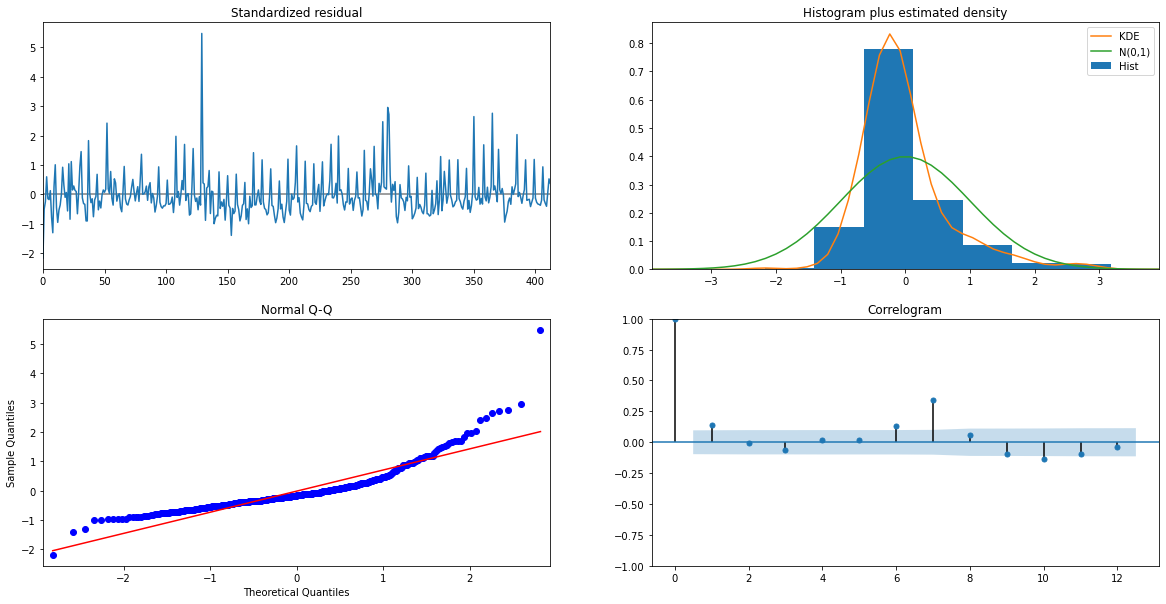

In [19]:
sar.plot_diagnostics(lags=12,figsize = (20,10),);

### Forecast untuk 31 hari ke depan (SARIMA)

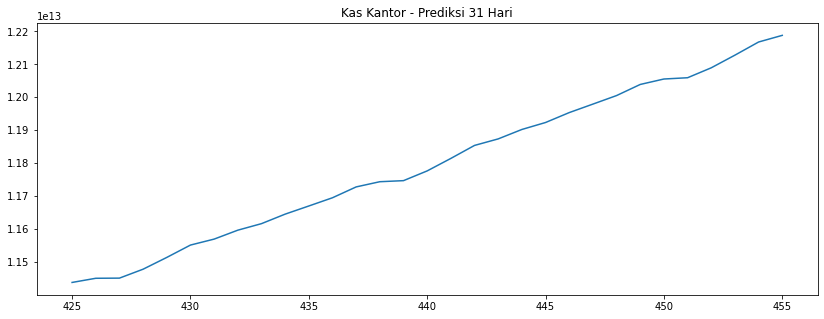

In [20]:
pd.plotting.register_matplotlib_converters()
sar.get_forecast(31).predicted_mean.plot(title = "Kas Kantor - Prediksi 31 Hari",
                                        figsize=(14, 5));

Berikutnya kita akan melakukan pemodelan dengan menggunakan AutoARIMA. Memodelkan secara manual merupakan proses yang iteratif karena kita harus memilih banyak parameter dan melakukan penilaian statistik yang penulis tidak lakukan disini.

## AutoARIMA

In [21]:
stepwise_model = pm.auto_arima(train['kas_kantor'], start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=0, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=22730.816, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=22019.174, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=22435.452, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=23202.736, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=22108.568, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=21971.676, Time=2.50 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=22725.566, Time=1.06 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=21966.795, Time=2.26 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=22006.076, Time=0.50 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.76 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept 

In [22]:
from datetime import timedelta

# Fungsi untuk membuat dataframe hasil prediksi
def future_preds_df(model,series,num_days):
    pred_first = series.index.max()+timedelta(1)
    pred_last = series.index.max()+timedelta(num_days)
    date_range_index = pd.date_range(pred_first,pred_last,freq='D')
    vals = model.predict(n_periods = num_days)
    return pd.DataFrame(vals,index = date_range_index)

Text(0.5, 1.0, 'Data Asli + Prediksi dari Kas Kantor')

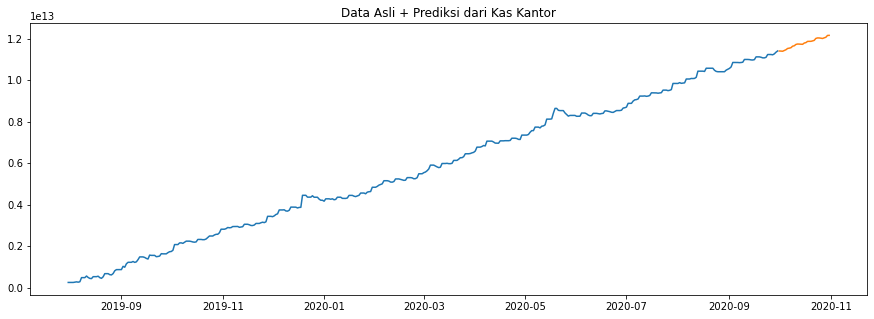

In [23]:
preds = future_preds_df(stepwise_model,train['kas_kantor'],31)
plt.figure(figsize=(15,5));
plt.plot(train['kas_kantor']);
plt.plot(preds);
plt.title("Data Asli + Prediksi dari Kas Kantor")

#### **Banyak uji statistik time-series yang penulis lewatkan karena keterbatasan waktu**

Berikutnya kita akan melakukan forecast menggunakan Prophet

## Prophet

In [24]:
from fbprophet import Prophet
plt.rcParams['figure.figsize'] = [15, 4]

Pada Prophet, data harus dalam format kolom **ds** dan **y**, dimana **ds** adalah kolom yang berisi tanggal dan **y** adalah kolom dari variabel yang kita ingin prediksi.

In [25]:
# Baca ulang data
train = pd.read_csv("../input/bri-data-hackathon-cr-optimization/train.csv")
# Ambil kolom yang kita minati saja
train = train[['periode', 'kas_kantor']]
# Ubah nama kolom
train = train.rename(columns={'periode':'ds',
                              'kas_kantor':'y'})
train.head()

,ds,y
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11


### Inisialisasi model, fit dan predict

In [26]:
m = Prophet()
m.fit(train)

In [27]:
# Melakukan prediksi
future = m.make_future_dataframe(periods=31)
forecast = m.predict(future)

Hasil prediksi Prophet terdiri dari beberapa komponen seperti rata-rata prediksi, batas atas, batas bawah dan komponen lainnya.

In [28]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

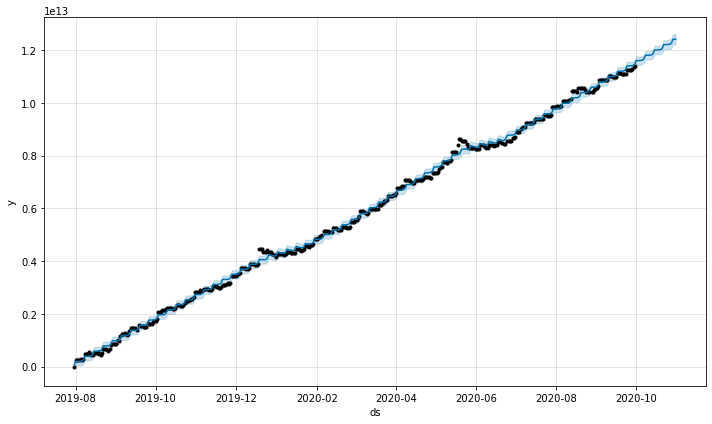

In [29]:
# Plot hasil forecast
m.plot(forecast);

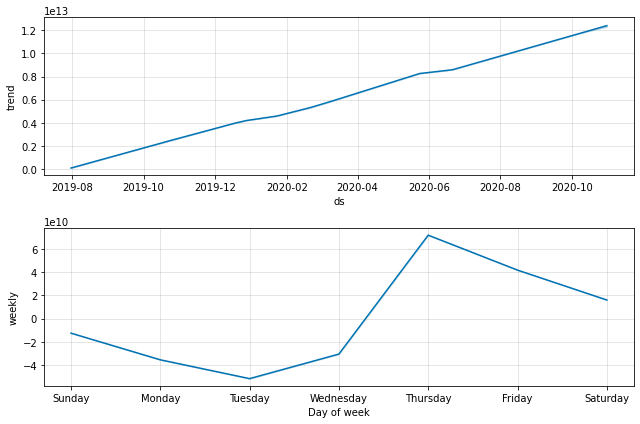

In [30]:
# Plot masing-masing komponen
m.plot_components(forecast);

### Untuk sementara, sampai disini dulu ya.
### Untuk mempelajari Prophet lebih lanjut dan untuk teknik yang lebih advanced, silakan kunjungi laman dari Prophet: https://facebook.github.io/prophet/

#### To-do list:
1. Advanced Prophet
2. Hari libur, tanggal penting, dll
3. Penanganan outlier
4. Multivariate time-series
5. Transformasi data
6. Forecast komponen dari data target